<a href="https://colab.research.google.com/github/annie-755/graph_theory/blob/main/IMS24030__DSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computed 3 snapshots (including iteration 0).
        (0, degree)  (0, betweenness)  (0, closeness)  (0, clustering)  \
iter_0     0.484848          0.437635        0.568966         0.150000   
iter_1     0.933333          0.689683        0.937500         0.186813   
iter_2     0.833333          0.377778        0.857143         0.400000   

        (1, degree)  (1, betweenness)  (1, closeness)  (1, clustering)  \
iter_0     0.272727          0.053937        0.485294         0.333333   
iter_1     0.533333          0.073810        0.652174         0.428571   
iter_2     0.875000          0.654762        0.888889         0.238095   

        (2, degree)  (2, betweenness)  ...  (31, closeness)  (31, clustering)  \
iter_0     0.303030          0.143657  ...         0.540984               0.2   
iter_1     0.333333          0.002381  ...         0.586207               0.3   
iter_2     0.500000          0.011905  ...         0.586207               0.3   

        (32, degree)  (32, betweenn

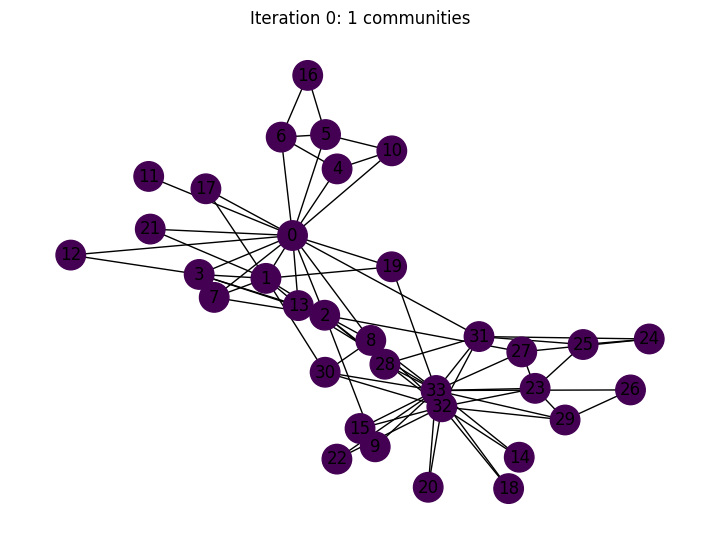

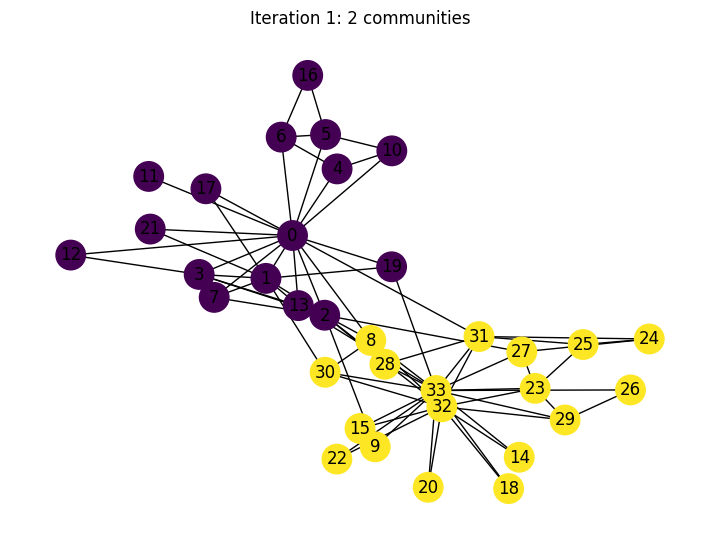

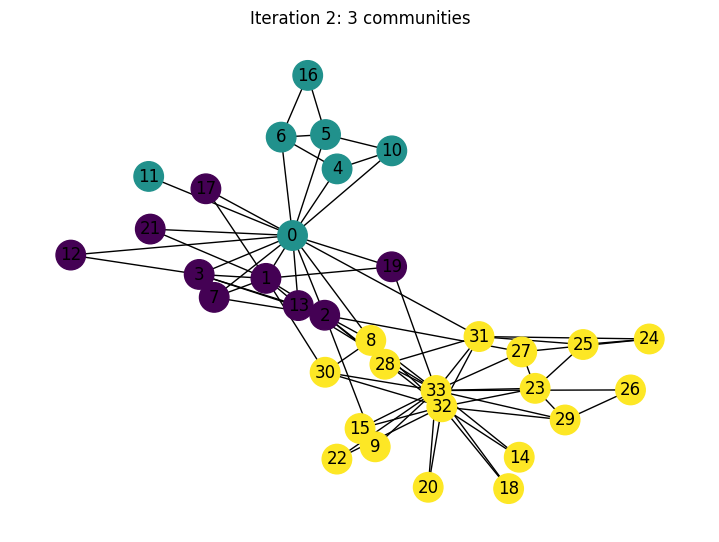

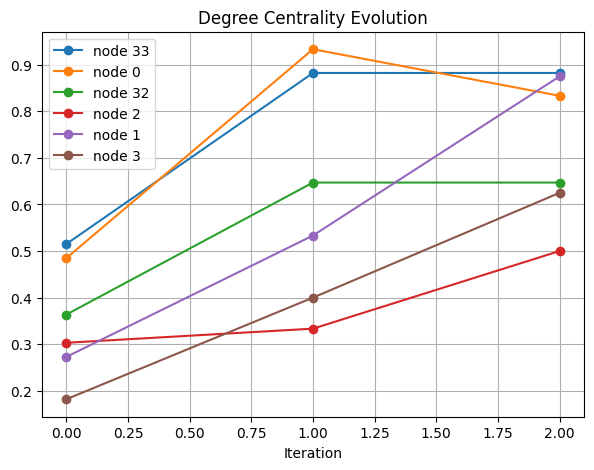

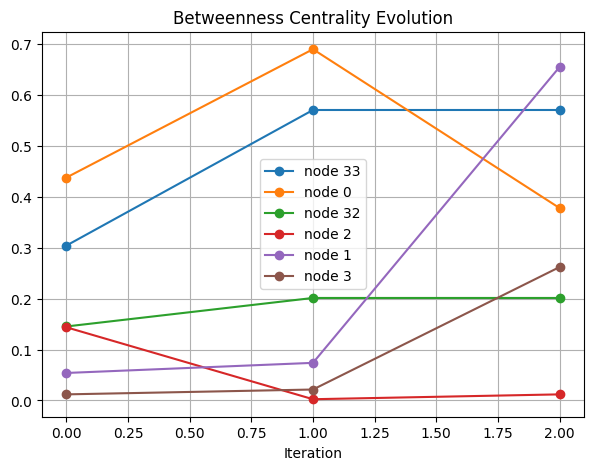

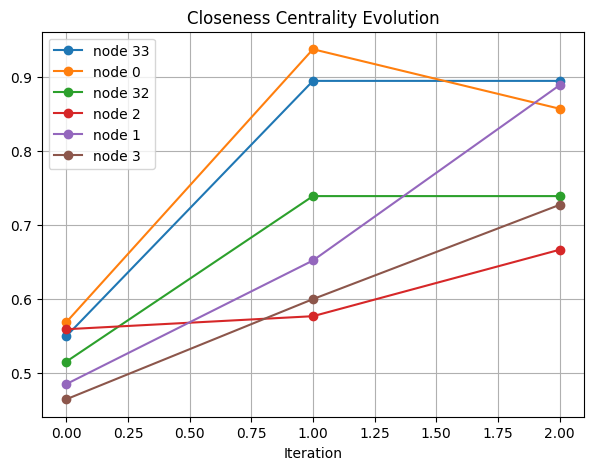

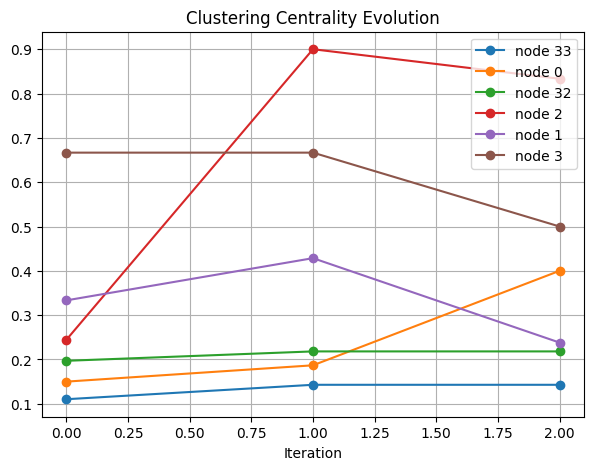

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import isclose
import os


#  MODULARITY MATRIX FOR SUBGRAPH
def modularity_matrix_subgraph(G, nodes):
    A = nx.to_numpy_array(G, nodelist=nodes)
    k = A.sum(axis=1)
    m = A.sum() / 2.0
    if isclose(m, 0.0):
        B = A
    else:
        B = A - np.outer(k, k) / (2.0 * m)
    return B


# LEADING EIGENPAIR
def leading_eigenpair(B):
    vals, vecs = np.linalg.eig(B)
    idx = np.argmax(vals.real)
    return vals.real[idx], vecs[:, idx].real


# SPLIT COMMUNITY
def split_community(G, nodes):
    B = modularity_matrix_subgraph(G, nodes)
    lam, u = leading_eigenpair(B)
    if lam <= 1e-8:
        return None, None, lam

    signs = np.sign(u)
    signs[signs == 0] = 1
    g1 = [nodes[i] for i in range(len(nodes)) if signs[i] > 0]
    g2 = [nodes[i] for i in range(len(nodes)) if signs[i] < 0]

    if len(g1) == 0 or len(g2) == 0:
        return None, None, lam
    return g1, g2, lam


# RECURSIVE SPECTRAL PARTITION
def recursive_spectral_partition(G, max_splits=2):
    communities = [list(G.nodes())]
    snapshots = [communities.copy()]
    lam_history = []

    for _ in range(max_splits):
        best_idx = None
        best_lam = -1e9

        # Find best community to split
        for i, comm in enumerate(communities):
            if len(comm) <= 1:
                continue
            B = modularity_matrix_subgraph(G, comm)
            lam, _ = leading_eigenpair(B)
            if lam > best_lam:
                best_lam = lam
                best_idx = i

        if best_idx is None or best_lam <= 1e-8:
            lam_history.append(best_lam)
            break

        g1, g2, lam_used = split_community(G, communities[best_idx])
        if g1 is None:
            lam_history.append(lam_used)
            break

        # Replace old community with 2 new ones
        communities = (
            communities[:best_idx] + [g1, g2] + communities[best_idx+1:]
        )
        snapshots.append(communities.copy())
        lam_history.append(lam_used)

    return snapshots, lam_history



G = nx.karate_club_graph()
snapshots, lam_history = recursive_spectral_partition(G, max_splits=2)

print(f"Computed {len(snapshots)} snapshots (including iteration 0).")


#  CENTRALITIES
metrics = ["degree", "betweenness", "closeness", "clustering"]
data = {it: {n: {} for n in G.nodes()} for it in range(len(snapshots))}

for it, comms in enumerate(snapshots):
    for comm in comms:
        sub = G.subgraph(comm)
        deg = nx.degree_centrality(sub)
        bet = nx.betweenness_centrality(sub)
        clo = nx.closeness_centrality(sub)
        clu = nx.clustering(sub)

        for n in comm:
            data[it][n]["degree"] = deg.get(n, 0)
            data[it][n]["betweenness"] = bet.get(n, 0)
            data[it][n]["closeness"] = clo.get(n, 0)
            data[it][n]["clustering"] = clu.get(n, 0)


#  DATAFRAME
rows = []
metrics_order = ["degree", "betweenness", "closeness", "clustering"]

for it in range(len(snapshots)):
    row = {}
    for node in sorted(G.nodes()):
        for m in metrics_order:
            row[(node, m)] = data[it][node][m]
    rows.append(row)

df = pd.DataFrame(rows, index=[f"iter_{i}" for i in range(len(snapshots))])
df = df.reindex(
    sorted(df.columns, key=lambda x: (x[0], metrics_order.index(x[1]))),
    axis=1
)

print(df)


# GRAPH PLOTS
pos = nx.spring_layout(G, seed=42)

for it, comms in enumerate(snapshots):
    assign = {}
    for cid, comm in enumerate(comms):
        for node in comm:
            assign[node] = cid

    node_colors = [assign[n] for n in G.nodes()]

    plt.figure(figsize=(7,5))
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=450)
    plt.title(f"Iteration {it}: {len(comms)} communities")
    plt.show()


# METRIC EVOLUTION PLOTS
top_nodes = sorted(G.degree, key=lambda t: t[1], reverse=True)[:6]
top_nodes = [t[0] for t in top_nodes]
iters = range(len(snapshots))

for m in metrics_order:
    plt.figure(figsize=(7,5))
    for node in top_nodes:
        vals = [data[it][node][m] for it in iters]
        plt.plot(iters, vals, marker='o', label=f"node {node}")
    plt.title(f"{m.capitalize()} Centrality Evolution")
    plt.xlabel("Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()





